In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import networkx as nx
import cirq

Create a random graph

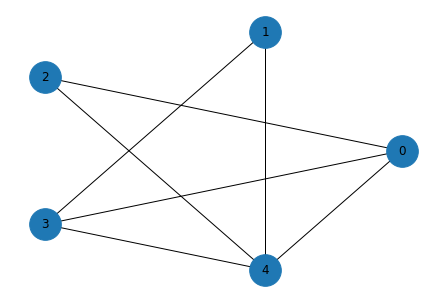

In [2]:
graph = nx.generators.random_graphs.erdos_renyi_graph(n=5,p=0.5)
nx.draw_circular(graph, node_size=1000, with_labels=True)
plt.show()

In [3]:
def product(*args, repeat=1):
    # product('ABCD', 'xy') --> Ax Ay Bx By Cx Cy Dx Dy
    # product(range(2), repeat=3) --> 000 001 010 011 100 101 110 111
    pools = [list(pool) for pool in args] * repeat
    result = [[]]
    for pool in pools:
        result = [x+[y] for x in result for y in pool]
    for prod in result:
        yield list(prod)
        
# Number of edges
M = len(graph.edges)
# Number of nodes
N = len(graph.nodes)
# Adjacency matrix
A = nx.adjacency_matrix(graph).todense()

# Generate a list of all possible n‐tuples of elements from {1,-1} and
# organize them as a (2^N x N) matrix. In other words create all possible
# solutions to the problem.
s = np.array(list(product([1, -1], repeat=N)))

# Construct the the cost function for Max Cut: C = 1/2 Sum(Z_i*Z_j) - M/2
# Note: This is the minimization version
C = 1/2*(np.diag(s@np.triu(A)@s.T) - M)

# Find the args that corresponds to the minimums of the cost function
args = np.where(C == min(C))

Create the ideal state 
$$
\rho_\text{ideal} = |\psi_\text{GS}\rangle\langle \psi_\text{GS}|
$$

In [4]:
rho_ideal = np.zeros(2**5)
for arg in args[0]:
    rho_ideal[arg] = 1
rho_ideal = rho_ideal / np.sum(rho_ideal) # normalize
print("Energy of ground state:",round(np.sum(rho_ideal*C),3))

Energy of ground state: -5.0


Create a thermal state 
$$
\rho_\text{thermal} = \frac{1}{Z}\sum_{i=1}^d e^{-\beta E_i}|\psi_i\rangle \langle\psi_i|
$$

In [5]:
beta = 0.1 # temperature
rho_thermal = np.exp(beta*C)
rho_thermal = rho_thermal / np.sum(rho_thermal) # normalize
print("Average energy of thermal state:",round(np.sum(rho_thermal*C),3))

Average energy of thermal state: -3.313


Create a mixed state between the ideal and thermal state
$$
\rho = 0.5 \rho_\mathrm{ideal} + 0.5\rho_\text{thermal}
$$

In [6]:
rho = 0.5*rho_ideal + 0.5*rho_thermal

Calculate the probability of being in the ground state

In [7]:
sum(rho[arg] for arg in args[0])

0.6066103507645391

## Virtual distillation

We first make $\rho$ into a proper matrix

In [8]:
rho_dm = np.diag(rho)

Next we construct the normalized square of $\rho$

$$
\frac{\rho^2}{\mathrm{Tr}(\rho^2)}
$$

In [9]:
rho_sq_norm = rho_dm@rho_dm / np.trace(rho_dm@rho_dm)
rho_sq_norm = rho_sq_norm.astype('complex64')

Now we can calculate what the mitigated cost given depolarizing noise in the virtual distillation circuit

In [10]:
# probability of error
p_error = 0.1

# create qubits
qubits = cirq.LineQubit.range(len(graph.nodes))

# init expval
expval = 0 
for u, v in graph.edges:
    zz = cirq.PauliString(cirq.Z(qubits[u])) * cirq.PauliString(cirq.Z(qubits[v]))
    expval_zz = zz.expectation_from_density_matrix(
        state=rho_sq_norm, 
        qubit_map={q: i for i, q in enumerate(qubits)}
    ).real
    expval += (1-p_error)**2 * expval_zz
    
mitigated_cost = - 1/2 * (expval - M)
print('Mitigated cost:', round(mitigated_cost,3))

Mitigated cost: 4.482


### Calculate the variance of the estimator

Now we are interested in the variance

In [11]:
def virtual_distillation(rho:np.array, meas:bool=True, with_noise:object=None):
    shape = rho.shape
    num_q = int(np.log2(shape[0])) # number of qubits in rho
    qubits = cirq.LineQubit.range(2*num_q+1) # Create qubits
    
    """Create the virtual distillation circuit."""
    circuit = cirq.Circuit() # Initialize circuit
            
    for q in range(num_q):
        circuit.append(cirq.FREDKIN(qubits[0], qubits[q+1], qubits[num_q+(q+1)]))
        if with_noise != None:
            circuit.append(with_noise.on_each(qubits[0], qubits[q+1], qubits[num_q+(q+1)]))

    return circuit

In [12]:
"""Create a Depolarizing channel."""
class DepolarizingChannel(cirq.SingleQubitGate):
    def __init__(self, p: float) -> None:
        self._p = p

    def _mixture_(self):
        ps = [1.0 - 3*self._p/4, self._p/4, self._p/4, self._p/4]
        ops = [cirq.unitary(cirq.I), cirq.unitary(cirq.X), cirq.unitary(cirq.Y), cirq.unitary(cirq.Z)]
        return tuple(zip(ps, ops))

    def _has_mixture_(self) -> bool:
        return True

    def _circuit_diagram_info_(self, args) -> str:
        return f"D({self._p})"

"""Create a Dephasing channel."""
class DephasingChannel(cirq.SingleQubitGate):
    def __init__(self, p: float) -> None:
        self._p = p

    def _mixture_(self):
        ps = [1.0 - self._p/2, self._p/2]
        ops = [cirq.unitary(cirq.I), cirq.unitary(cirq.Z)]
        return tuple(zip(ps, ops))

    def _has_mixture_(self) -> bool:
        return True

    def _circuit_diagram_info_(self, args) -> str:
        return f"Lambda({self._p})"

In [13]:
"""Setup variables"""
rho_sq = rho_dm@rho_dm # square of rho
shape = rho_dm.shape # shape of rho
num_q = int(np.log2(shape[0])) # number of qubits in rho

"""Prepare the initial state of the ancilla"""
ancilla = 1/2*np.array([[1,1],[1,1]])

"""Prepare the total initial state"""
initial_state = cirq.kron(ancilla,rho_dm,rho_dm)

"""Change data type to complex64"""
initial_state = initial_state.astype('complex64')

"""Simulating with the density matrix simulator."""
simulator = cirq.DensityMatrixSimulator(
    split_untangled_states=True
)

"""Create the virtial distillation circuit"""
vd_circuit = virtual_distillation(
    rho,
    with_noise=DepolarizingChannel(p=0.1)
)

"""Simulate the circuit"""
qubits = cirq.LineQubit.range(2*num_q+1) # Create qubits
result = simulator.simulate(
    vd_circuit,
    initial_state=initial_state,
    qubit_order=qubits
)
# output density matrix
rho_out = result.final_density_matrix

In [14]:
""""Symmeterized version of the cost Hamiltonian H_C"""
C_2 = 0 
for (u,v) in graph.edges: 
    C_2 += 1/4 * (1-cirq.PauliString(cirq.Z(qubits[u+1])) * cirq.PauliString(cirq.Z(qubits[v+1]))) \
         + 1/4 * (1-cirq.PauliString(cirq.Z(qubits[u+(num_q+1)])) * cirq.PauliString(cirq.Z(qubits[v+(num_q+1)])))
    
"""Ancilla Observable"""
X_0 = cirq.PauliString(cirq.X(qubits[0]))

In [15]:
y = X_0 * C_2 # observable numerator
numerator = y.expectation_from_density_matrix(
    state=rho_out, 
    qubit_map={q: i for i, q in enumerate(qubits)}
)

denominator = X_0.expectation_from_density_matrix(
    state=rho_out, 
    qubit_map={q: i for i, q in enumerate(qubits)}
)

mitigated_cost = (numerator / denominator).real
print('Mitigated cost', round(mitigated_cost,5))

Mitigated cost 4.48194


### Version

In [16]:
import platform
print("python:",platform.python_version())
print('cirq:',cirq.__version__)
print('numpy:',np.__version__)
print('sympy:',sp.__version__)
print('networkx:',nx.__version__)

python: 3.9.9
cirq: 0.13.1
numpy: 1.21.5
sympy: 1.9
networkx: 2.6.3
